# Logit models

Linear regressions ((ordinary least squares, or OLS)) tells us about the association between a **dependent**, or Y variable, and a set of **independent**, or X variables. Regression does not tell us anything about one variable causing another or if the correlations we find have any real meaning. It is simply a [statistical technique](https://www.statology.org/linear-regression-assumptions/) for finding a linear relationship between two variables. The meaning of that relationship is up to us and the ideas that we are working with. In finance, we usually have an economic model in mind, such as the CAPM, that gives meaning to the relationship that we find.

A **logit regression** does something similar, except that it was developed for when our dependent variable is **binary**, a Yes or No. Logistic regression is a regression model where the response variable Y is **categorical**, as opposed to **continuous**. These types of models are used for **classification**. Why do we need a new model? We want a model that can give us **probabilities** for an event. Regular regression isn't set up to do this.

We will look at a type of data that is commonly used with logit models in finance: credit card default data. This data set has a **binary outcome**. Did the credit card user default? Yes or No? 1 or 0?

This data is from the DataCamp module on credit risk analysis.

We'll start with some usual set-up, bringing the data in, and taking a peak.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

loans = pd.read_csv('https://raw.githubusercontent.com/aaiken1/fin-data-analysis-python/main/data/loan_data.csv', index_col=0)  

There are no dates in this data, so no dates to parse. The first column is simply the row number, so I'll make that my index.

## Cleaning our data

Let's get started by just looking at what we have.

In [2]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29092 entries, 1 to 29092
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   loan_status     29092 non-null  int64  
 1   loan_amnt       29092 non-null  int64  
 2   int_rate        26316 non-null  float64
 3   grade           29092 non-null  object 
 4   emp_length      28283 non-null  float64
 5   home_ownership  29092 non-null  object 
 6   annual_inc      29092 non-null  float64
 7   age             29092 non-null  int64  
dtypes: float64(3), int64(3), object(2)
memory usage: 2.0+ MB


We are interested in explaining the *loan_status* variable. In this data set, *loan_status = 1* means that the credit card holder has defaulted on their loan. What explains the defaults? THe loan amount? Their income? Employment status? Their age?

In [3]:
loans.describe()

,loan_status,loan_amnt,int_rate,emp_length,annual_inc,age
count,29092.000000,29092.000000,26316.000000,28283.000000,2.909200e+04,29092.000000
mean,0.110924,9593.505947,11.004567,6.145282,6.716883e+04,27.702117
std,0.314043,6323.416157,3.239012,6.677632,6.360652e+04,6.231927
min,0.000000,500.000000,5.420000,0.000000,4.000000e+03,20.000000
25%,0.000000,5000.000000,7.900000,2.000000,4.000000e+04,23.000000
50%,0.000000,8000.000000,10.990000,4.000000,5.642400e+04,26.000000
75%,0.000000,12250.000000,13.470000,8.000000,8.000000e+04,30.000000
max,1.000000,35000.000000,23.220000,62.000000,6.000000e+06,144.000000


Note the units. Loan amount appears to be in dollars. The max of \$35,000 reflects the general limit on credit card borrowing - these aren't mortgages. Interest rate is in percents. The median credit card rate in this sample is 10.99%. Employment length is in years, as is age. Annual income is in dollars. Note the max values for *annual_inc* and *age*!

Home ownership and grade do not appear, since they are text variables, not numeric. Grade is some kind of overall measure of loan quality.

Let's convert the two object variables to [categorical variables](https://www.tutorialspoint.com/python_pandas/python_pandas_categorical_data.htm) so that we can deal with them. This code puts all of the **object** columns into a list and then loops through that list to change those columsn to type **category**. 

In [4]:
list_str_obj_cols = loans.columns[loans.dtypes == 'object'].tolist()
for str_obj_col in list_str_obj_cols:
    loans[str_obj_col] = loans[str_obj_col].astype('category')

loans.dtypes

loan_status          int64
loan_amnt            int64
int_rate           float64
grade             category
emp_length         float64
home_ownership    category
annual_inc         float64
age                  int64
dtype: object

Looks good! I'm now going to add `include='all'` to `describe` to give more information about these categorical variables.


In [5]:
loans.describe(include='all')

,loan_status,loan_amnt,int_rate,grade,emp_length,home_ownership,annual_inc,age
count,29092.000000,29092.000000,26316.000000,29092,28283.000000,29092,2.909200e+04,29092.000000
unique,NaN,NaN,NaN,7,NaN,4,NaN,NaN
top,NaN,NaN,NaN,A,NaN,RENT,NaN,NaN
freq,NaN,NaN,NaN,9649,NaN,14692,NaN,NaN
mean,0.110924,9593.505947,11.004567,NaN,6.145282,NaN,6.716883e+04,27.702117
std,0.314043,6323.416157,3.239012,NaN,6.677632,NaN,6.360652e+04,6.231927
min,0.000000,500.000000,5.420000,NaN,0.000000,NaN,4.000000e+03,20.000000
25%,0.000000,5000.000000,7.900000,NaN,2.000000,NaN,4.000000e+04,23.000000
50%,0.000000,8000.000000,10.990000,NaN,4.000000,NaN,5.642400e+04,26.000000
75%,0.000000,12250.000000,13.470000,NaN,8.000000,NaN,8.000000e+04,30.000000


This doesn't show us all of the possible values, but at least we can see the number of values that aren't missing, as well as a count of unique values. Let's get a list of possible values for each categorical variable.

In [6]:
loans['grade'].value_counts()

A    9649
B    9329
C    5748
D    3231
E     868
F     211
G      56
Name: grade, dtype: int64

In [7]:
loans['home_ownership'].value_counts()

RENT        14692
MORTGAGE    12002
OWN          2301
OTHER          97
Name: home_ownership, dtype: int64


We can use `sns.pairplot` from the `seaborn` library to get a nice visualization of the relationships between our variables. The diagonal plots show the **denisity plots** for that one variable, but split between *loan_status. The off-diagonal plots show the relationship between two of the explanatory (X) variables, but with each observation color-coded based on a third variable, their default status. 

Orange means that the person has defaulted. 

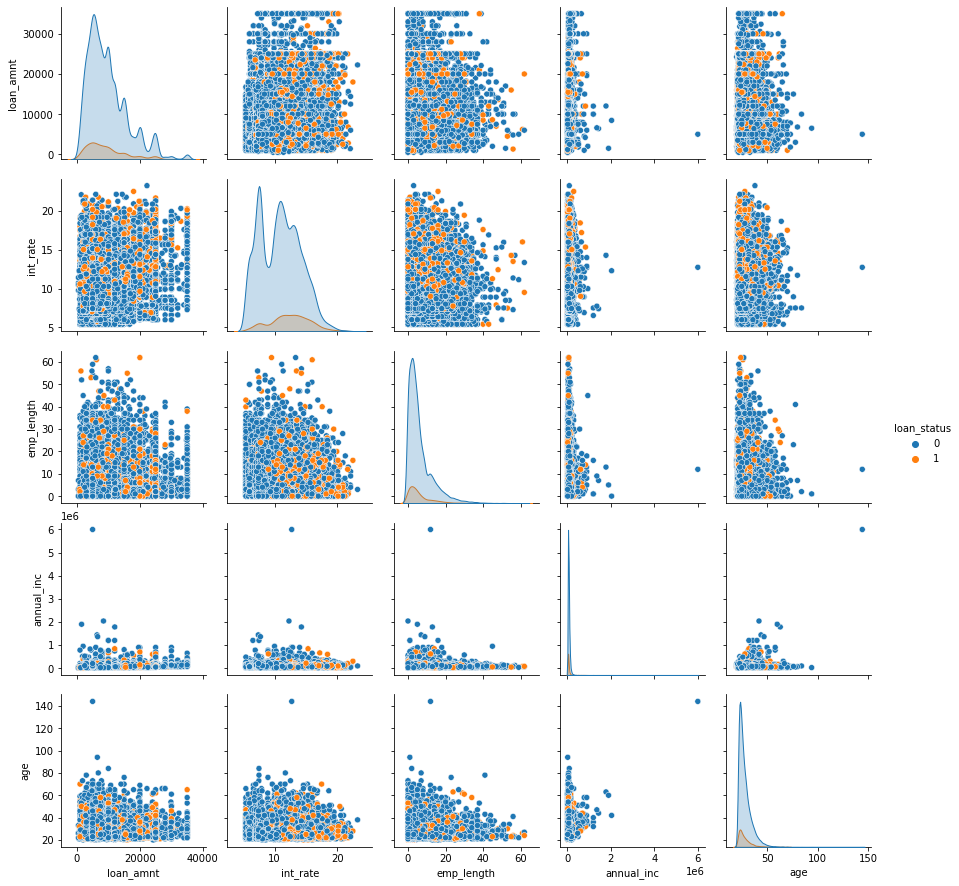

In [8]:
sns.pairplot(loans, hue='loan_status')


What jumps out to you? First I see some outliers in age. Someone is over 140 years old in the data! We should drop that observation.

There's also one individual with a really large annual income. We could also drop that one observation. Outlier observations can overly influence our regression results, though there are techniques for dealing with that. 

We can also visually see some of the relationships. Look up and down the *int_rate* column. Generally, there are more orange dots when the interest rate is higher. Look at the second row, second column. The mean of the smaller density is to the right of the larger one. The smaller one has an orange border and shows the distribution of interest rates on the loans that defaulted.

Look at the third row, second column. There are more orange dots in the higher interest rate, shorter employment length part of the distribution. Look at the fifth row, second column. Loans that defaulted tended to be younger and with higher interest rates.

I am going to clean up two of the outliers - the one for annual income and the one for age. I'll also drop any row with a missing value. 

When done, I'll re-check my data.

In [9]:
loans = loans[loans['annual_inc'] < 6000000]
loans = loans[loans['age'] < 144]

loans = loans.dropna()

loans.describe(include='all')


,loan_status,loan_amnt,int_rate,grade,emp_length,home_ownership,annual_inc,age
count,25570.000000,25570.000000,25570.000000,25570,25570.000000,25570,2.557000e+04,25570.000000
unique,NaN,NaN,NaN,7,NaN,4,NaN,NaN
top,NaN,NaN,NaN,A,NaN,RENT,NaN,NaN
freq,NaN,NaN,NaN,8412,NaN,13015,NaN,NaN
mean,0.109190,9655.154478,11.034409,NaN,6.127219,NaN,6.750489e+04,27.695190
std,0.311884,6324.540307,3.228964,NaN,6.653610,NaN,5.214082e+04,6.163362
min,0.000000,500.000000,5.420000,NaN,0.000000,NaN,4.000000e+03,20.000000
25%,0.000000,5000.000000,7.900000,NaN,2.000000,NaN,4.000000e+04,23.000000
50%,0.000000,8000.000000,10.990000,NaN,4.000000,NaN,5.700600e+04,26.000000
75%,0.000000,12500.000000,13.480000,NaN,8.000000,NaN,8.000400e+04,30.000000


That seems better. Note that each variable now has the same count. Only rows with all of the information are included. This isn't necessarily best practices when it comes to data. You want to know why your data are missing. You can sometimes fill in the missing data using a variety of methods, as well. 

We can also use the basic `pd.crosstabs` function from `pandas` to look at variables across our categorical data.


In [10]:
pd.crosstab(loans['loan_status'], loans['home_ownership'])

home_ownership,MORTGAGE,OTHER,OWN,RENT
loan_status,,,,
0,9506,69,1740,11463
1,1019,16,205,1552


We can **normalize** these counts as well, either over all values, by row, or by column. 

In [11]:
pd.crosstab(loans['loan_status'], loans['home_ownership'], normalize = 'all')

home_ownership,MORTGAGE,OTHER,OWN,RENT
loan_status,,,,
0,0.371764,0.002698,0.068048,0.448299
1,0.039851,0.000626,0.008017,0.060696


This tells us that about 6% of our sample are renters who defaulted. We can try normalizing by column, too.

In [12]:
pd.crosstab(loans['loan_status'], loans['home_ownership'], normalize = 'columns')

home_ownership,MORTGAGE,OTHER,OWN,RENT
loan_status,,,,
0,0.903183,0.811765,0.894602,0.880753
1,0.096817,0.188235,0.105398,0.119247


Now, each column adds up to 1. 11.9% of all renters in the sample defaulted. 

Finally, we can look at the **margins**. These add up values by row and column. 

In [13]:
pd.crosstab(loans['loan_status'], loans['home_ownership'], normalize = 'all', margins = True)

home_ownership,MORTGAGE,OTHER,OWN,RENT,All
loan_status,,,,,
0,0.371764,0.002698,0.068048,0.448299,0.89081
1,0.039851,0.000626,0.008017,0.060696,0.10919
All,0.411615,0.003324,0.076066,0.508995,1.00000


So, 10.9% of the full sample defaulted on their loans. About 51% are the full sample are renters. And, about 6% of renters defaulted. 

You can play around with the options to get the counts or percents that you want.

## Linear regression with a binary outcome

Now, let's run a regular linear regression to see what the relationship between loan status (default = 1) and annual income is. 

In [14]:
results_ols = smf.ols("loan_status ~ annual_inc", data=loans).fit()
print(results_ols.summary())

                            OLS Regression Results                            
Dep. Variable:            loan_status   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     67.76
Date:                Sun, 01 May 2022   Prob (F-statistic):           1.93e-16
Time:                        15:16:08   Log-Likelihood:                -6455.7
No. Observations:               25570   AIC:                         1.292e+04
Df Residuals:                   25568   BIC:                         1.293e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1300      0.003     40.781      0.0

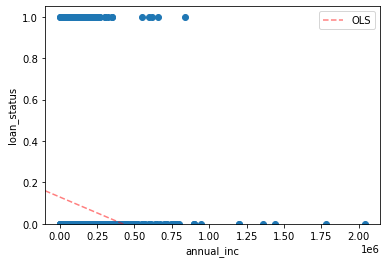

In [15]:
fig, ax = plt.subplots()
ax.scatter(loans["annual_inc"], loans["loan_status"])
sm.graphics.abline_plot(model_results=results_ols, ax=ax, color="red", label="OLS", alpha=0.5, ls="--")
ax.legend()
ax.set_xlabel("annual_inc")
ax.set_ylabel("loan_status")
ax.set_ylim(0, None)
plt.show()

Well, that sure looks strange! Linear regression shows loan status going negative!

Let's do the same thing with `seaborn`. It's very easy to add a regression line, like you would in Excel. 

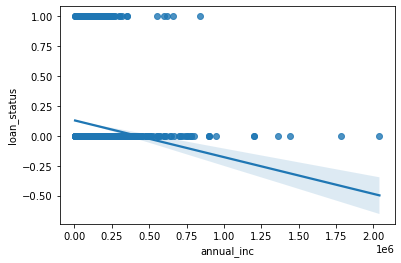

In [16]:
sns.regplot(x="annual_inc", y="loan_status", data=loans);

Yeah, that really doesn't make sense. `seaborn` lets us also add the fit from a logistic regression, though. 

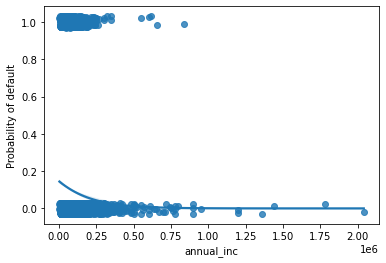

In [17]:
sns.regplot(x="annual_inc", y="loan_status", data=loans, logistic=True, y_jitter=.03)
plt.ylabel("Probability of default");

OK, that still looks a bit strange, but at least loan status is never below 0!

### Categorical variables, again

We'll add the other variables to the regression, for completeness. To do this, though, I'm going to take my categorical variables and create new **dummy/indicator variables**. This will take the categories and create new columns. These new columns will take the value of 1 or 0, depending on whether or not that observation is in that category.

I'll use [pd.get_dummies](https://www.sharpsightlabs.com/blog/pandas-get-dummies/) to do this. I then concatenate, or combine, this new set of indicator variables to my original data. The `prefix=` helps me name the new variables.


In [18]:
loans= pd.concat((loans, pd.get_dummies(loans['grade'], prefix='loan_grade')), axis = 1)
loans= pd.concat((loans, pd.get_dummies(loans['home_ownership'], prefix='home')), axis = 1)

You don't have to create the numeric indicator variables for the regression models. However, when dealing with indicators, you need to drop one of them from the model. For example, for home ownership, you can't include *home_mortgage*, *home_rent*, *home_own*, and *home_other*. You always have to drop one category, or the regression won't work. This is because the four variables together are [perfectly multicollinear](https://www.dummies.com/article/business-careers-money/business/economics/perfect-multicollinearity-and-your-econometric-model-156469/).  

I find it easier sometimes to manipulate the model when I have a distinct indicator variable for my categorical variables. You can also use the `treatment=` option when specifying a variable as categorical directly in the model.

For example, let me run the OLS model with *home_ownership* included as a categorical variable. 

In [19]:
results_ols = smf.ols("loan_status ~ annual_inc + home_ownership", data=loans).fit()
print(results_ols.summary())

                            OLS Regression Results                            
Dep. Variable:            loan_status   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     21.92
Date:                Sun, 01 May 2022   Prob (F-statistic):           4.44e-18
Time:                        15:16:41   Log-Likelihood:                -6445.8
No. Observations:               25570   AIC:                         1.290e+04
Df Residuals:                   25565   BIC:                         1.294e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

That worked just fine. But, notice how *home_ownership[T.Mortgage]* is missing? The model automatically dropped it. So, the other *home_ownership* values are relative to having a mortgage. This may be just fine, of course! We can interpret the coefficient for renting, for example, as meaning that renters are more likely to default than those that have a mortgage. 

Here, I'll use my indicator variables and run a fully-specified model.

In [20]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25570 entries, 1 to 29091
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   loan_status     25570 non-null  int64   
 1   loan_amnt       25570 non-null  int64   
 2   int_rate        25570 non-null  float64 
 3   grade           25570 non-null  category
 4   emp_length      25570 non-null  float64 
 5   home_ownership  25570 non-null  category
 6   annual_inc      25570 non-null  float64 
 7   age             25570 non-null  int64   
 8   loan_grade_A    25570 non-null  uint8   
 9   loan_grade_B    25570 non-null  uint8   
 10  loan_grade_C    25570 non-null  uint8   
 11  loan_grade_D    25570 non-null  uint8   
 12  loan_grade_E    25570 non-null  uint8   
 13  loan_grade_F    25570 non-null  uint8   
 14  loan_grade_G    25570 non-null  uint8   
 15  home_MORTGAGE   25570 non-null  uint8   
 16  home_OTHER      25570 non-null  uint8   
 17  home_OWN    

I will exclude the top rated A loan indicator and the indicator for renting. Therefore, the other indicator variables will be relative to the excluded one.

In [21]:
results_ols = smf.ols("loan_status ~ loan_amnt + int_rate + emp_length + annual_inc + age + loan_grade_B + loan_grade_C + loan_grade_D + loan_grade_E + loan_grade_F + loan_grade_G + home_MORTGAGE + home_OWN + home_OTHER", data=loans).fit()
print(results_ols.summary())

                            OLS Regression Results                            
Dep. Variable:            loan_status   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     52.76
Date:                Sun, 01 May 2022   Prob (F-statistic):          2.32e-146
Time:                        15:16:42   Log-Likelihood:                -6125.3
No. Observations:               25570   AIC:                         1.228e+04
Df Residuals:                   25555   BIC:                         1.240e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0348      0.017      2.033

The interpretation of the signs on the coefficients is relatively straightforward. Larger credit card loans are less likely to default. Why? Lending is **endogenous** - it is chosen by the credit card company. They are more likely to allow larger balances for people less likely to default, all other things equal. Similarily, higher interest rates are related to more defaults. Larger annual incomes are associated with a smaller default rate. Lower loan grades, relative to A, are associated with more defaults. Finally, mortgage vs. renting doesn't seem to be that different, once you include all of these other variables.

## Logit models

OK, so let's look at a [logit model](https://www.andrewvillazon.com/logistic-regression-python-statsmodels/#fitting-a-logistic-regression). We can look at the signs of the coefficients from the OLS model, but we can't really interpret much else. Those coefficients are not probabilities. 

The true probability of defaulting must fall between 0 and 1. A **logit function**, show below, will satisfy this requirement. 

\begin{align}
{\displaystyle \mathbb{P}(Y=1\mid X) = \frac{1}{1 + e^{-X'\beta}}}
\end{align}

The left-hand side is the probability that Y = 1, or, in our case, that a loan is in default, **conditional** on the X variables, or the variables that we are using to predict loan status. The right-hand side is the function that **links** our X variables to the probability that Y = 1.

We will use `smf.logit` to estimate our logit model. This is an example of using a **generalized linear model (GLM)**, a class of models that includes logistic regression. You will also see logits described as **binomial** model. 

In the background, GLM uses **maximum likelihood** to fit the model. The basic intuition behind using maximum likelihood to fit a logistic regression model is as follows: 

We seek estimates for $\beta_0$ an $\beta_1$ that get us a predicted probability of default for each individual, $p(x_i)$, that corresponds as closely as possible to the individual’s actual observed default status. In other words, we plug in beta estimates until we get numbers "close" to 1 for those that default and "close" to zero for those that do not. This is done using what is called a **liklihood function**.

Ordinary least squares regression (OLS) actually works in a similar manner, where betas are chosen to minimize the sum of squared residuals (errors).

Essentially, we pick a model that we think can explain our data. This could be OLS, logit, or something else. Then, we find the parameters to plug into that model that give us the best possible predicted values based on minimizing some kind of error function.

Let's look at a logit with a discrete variable and a continuous X variable separately, in order to better understand how to interpret the output. 

### Logit with a discrete variable

We can start simply, again. This time, I'm going to just use the indicator for whether or not the person rents.

In [28]:
results_logit = smf.logit("loan_status ~ home_RENT", data = loans).fit()
print(results_logit.summary())

Optimization terminated successfully.
         Current function value: 0.344279
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:                25570
Model:                          Logit   Df Residuals:                    25568
Method:                           MLE   Df Model:                            1
Date:                Sun, 01 May 2022   Pseudo R-squ.:                0.001567
Time:                        15:20:43   Log-Likelihood:                -8803.2
converged:                       True   LL-Null:                       -8817.0
Covariance Type:            nonrobust   LLR p-value:                 1.473e-07
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.2110      0.030    -73.913      0.000      -2.270      -2.152
home_RENT      0.2114      0.

We didn't include renting in the linear model above, as it was the omitted indicator. But, here we can see that renting is associated with higher probability of default **relative to all of the other possibilities** and when not including any other variables in the model. 

Also note that we don't have *t*-statistics. With logit, you can *z*-scores. You can look at the p-values to see how you should interpret the score. The hypothesis is the same as in linear regression: can we reject the null hypothesis that this coefficient is zero?

The output from the logit regression is still hard to interpret, though. What does the coefficient on home_RENT of 0.2114 mean? This is a **log odds ratio**. Let's convert this to an **odds ratio**, which is easier to think about.

An odds ratio is defined as: 

\begin{align}
{\displaystyle \text{odds(success)} = \frac{p}{1-p}}
\end{align}


where p = probability of the event happening. So, an 80% chance of happening = .8/.2 = 4:1 odds. 1:1 odds is a 50/50 chance. The logit model gives us the log of this number. So, we can use the inverse of the log, the natural number e, to "undo" the log and get us the odds.

In [29]:
odds_ratios = pd.DataFrame(
    {
        "OR": results_logit.params,
        "Lower CI": results_logit.conf_int()[0],
        "Upper CI": results_logit.conf_int()[1],
    }
)
odds_ratios = np.exp(odds_ratios)
print(odds_ratios)

                 OR  Lower CI  Upper CI
Intercept  0.109589  0.103349  0.116206
home_RENT  1.235453  1.141559  1.337070


What do these numbers mean? If someone rents, this increases the odds of default by about 1.24 versus all other options.

For more about interpreting odds, see [here](https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-how-do-i-interpret-odds-ratios-in-logistic-regression/).

Odds ratios are **not probabilities**. Let's calculate the change in the probability of default as you from 0 to 1 for home_ownership_RENT. The [.get_margeff](https://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.DiscreteResults.get_margeff.html) function finds **marginal effects** and let's us move from odds ratios to probabilities.

Things get a bit complicated here. We have to find the marginal effect **at some point**, like the mean of the variable. This is like in economics, when you find [price elasticity](https://en.wikipedia.org/wiki/Price_elasticity_of_demand). I'm specifying that I have a dummy variable that I want to change and that I want the proportional change in *loan_status* for a change in *home_RENT*. This is the `eydx` specification.

In [33]:
p_marg_effect = results_logit.get_margeff(at='mean', method="eydx", dummy=True)
p_marg_effect.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:            loan_status
Method:                          eydx
At:                              mean
==============================================================================
            d(lny)/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
home_RENT      0.1884      0.036      5.238      0.000       0.118       0.259
==============================================================================
"""

You can interpret this as "going from not renting to renting is associated with an 18.84% increase *loan_status*." You can also specify `dydx`, which is the default.

In [34]:
p_marg_effect = results_logit.get_margeff(at='mean', method="dydx", dummy=True)
p_marg_effect.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:            loan_status
Method:                          dydx
At:                              mean
==============================================================================
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
home_RENT      0.0205      0.004      5.260      0.000       0.013       0.028
==============================================================================
"""

You can interpret this as "going from not renting to renting is associated with an 0.0205 increase in *loan_status* from the mean of *loan_status*."

### Logit with a continuous variable

We can also look at a continuous variable, like annual income.

In [25]:
results_logit = smf.logit("loan_status ~ annual_inc", data = loans).fit()
print(results_logit.summary())

Optimization terminated successfully.
         Current function value: 0.342899
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:                25570
Model:                          Logit   Df Residuals:                    25568
Method:                           MLE   Df Model:                            1
Date:                Sun, 01 May 2022   Pseudo R-squ.:                0.005569
Time:                        15:16:43   Log-Likelihood:                -8767.9
converged:                       True   LL-Null:                       -8817.0
Covariance Type:            nonrobust   LLR p-value:                 3.765e-23
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.7618      0.041    -43.111      0.000      -1.842      -1.682
annual_inc -5.309e-06   5.89e

Let's find our odds ratio for annual income. However, if we do that math exactly like above, we'll find the incremental odds change for a dollar more in annual income. That's going to be small! However, it is easy to change the increment for our continuous variable. 

In [26]:
increment = 10000

odds_ratios = pd.DataFrame(
    {
        "OR": results_logit.params * increment,
        "Lower CI": results_logit.conf_int()[0]* increment,
        "Upper CI": results_logit.conf_int()[1]* increment,
    }
)
odds_ratios = np.exp(odds_ratios)
print(odds_ratios)

                  OR  Lower CI  Upper CI
Intercept   0.000000  0.000000  0.000000
annual_inc  0.948297  0.937414  0.959307


We can read this number as "Increasing income by $10,000 reduces the odds of default by 1-0.948, or 0.052 (5.2%)."

We can also do marginal probabilities. I'll use the `eyex` method which tells us: If annual income increases by 1% from the mean value, what is the percentage change in the probability of default?

In [27]:
p_marg_effect = results_logit.get_margeff(at='mean', method="eyex")
p_marg_effect.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:            loan_status
Method:                          eyex
At:                              mean
=================================================================================
           d(lny)/d(lnx)    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
annual_inc       -0.3200      0.036     -8.976      0.000      -0.390      -0.250
=================================================================================
"""

If annual income, starting at the mean value, increases by 1%, then the probability of default drops by 0.32%. 

### Combining variables in a logit

Let's look at both annual income and renting together. It's good to get a feel for how to deal with both discrete and continuous variables.

I'm going to use the `C` categorical method and specify the "treatment", or omitted, indicator. This is instead of using my dummy variables that I created above. I just want to show you the different ways of doing the same thing.

In [51]:
results_logit = smf.logit("loan_status ~ loan_amnt + int_rate + emp_length + annual_inc + age + C(home_ownership, Treatment('MORTGAGE')) + C(grade, Treatment('A'))", data = loans).fit()
print(results_logit.summary())

Optimization terminated successfully.
         Current function value: 0.330446
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:                25570
Model:                          Logit   Df Residuals:                    25555
Method:                           MLE   Df Model:                           14
Date:                Sun, 01 May 2022   Pseudo R-squ.:                 0.04168
Time:                        15:41:11   Log-Likelihood:                -8449.5
converged:                       True   LL-Null:                       -8817.0
Covariance Type:            nonrobust   LLR p-value:                8.432e-148
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                     

Interpretation is similar. With all of the other variables included, renting doesn't seem to matter much for the probability of default vs. having a mortgage, since that coefficient is not significant. Remember, having a mortgage is the omitted indicator, so everything is relative to that. Notice how as you move down in loan grade that the probability of default increases, relative to being in the top category, "A", which was the omitted indicator. Annual income is again very significant and negative.

In [52]:
p_marg_effect = results_logit.get_margeff(at='overall', method="dydx")
p_marg_effect.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:            loan_status
Method:                          dydx
At:                           overall
=====================================================================================================================
                                                       dy/dx    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
C(home_ownership, Treatment('MORTGAGE'))[T.OTHER]     0.0523      0.027      1.942      0.052      -0.000       0.105
C(home_ownership, Treatment('MORTGAGE'))[T.OWN]      -0.0078      0.008     -0.998      0.318      -0.023       0.008
C(home_ownership, Treatment('MORTGAGE'))[T.RENT]     -0.0018      0.004     -0.413      0.679      -0.010       0.007
C(grade, Treatment('A'))[T.B]                         0.0331      0.009      3.713      0.000       0.016       0.051
C(grade, Treatment('A'))[T.C]                         0.0479      0.013      3.700      0.000       0.023       0.073
C(grade, Treatment('A'))[T.D]                         0.0574      0.016      3.492      0.000       0.025       0.090
C(grade, Treatment('A'))[T.E]                         0.0641      0.021      3.109      0.002       0.024       0.104
C(grade, Treatment('A'))[T.F]                         0.0976      0.027      3.625      0.000       0.045       0.150
C(grade, Treatment('A'))[T.G]                         0.1203      0.037      3.255      0.001       0.048       0.193
loan_amnt                                         -1.494e-07   3.42e-07     -0.437      0.662   -8.19e-07    5.21e-07
int_rate                                              0.0082      0.002      4.347      0.000       0.005       0.012
emp_length                                            0.0006      0.000      2.175      0.030    6.41e-05       0.001
annual_inc                                        -5.493e-07   6.48e-08     -8.477      0.000   -6.76e-07   -4.22e-07
age                                                  -0.0006      0.000     -1.748      0.081      -0.001    6.87e-05
=====================================================================================================================
"""